# Third assignment: Network Robustness

In [11]:
%matplotlib inline
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from scipy.io import mmread
from scipy import integrate


### First Experiment

Random Graph n=100 p=0,4

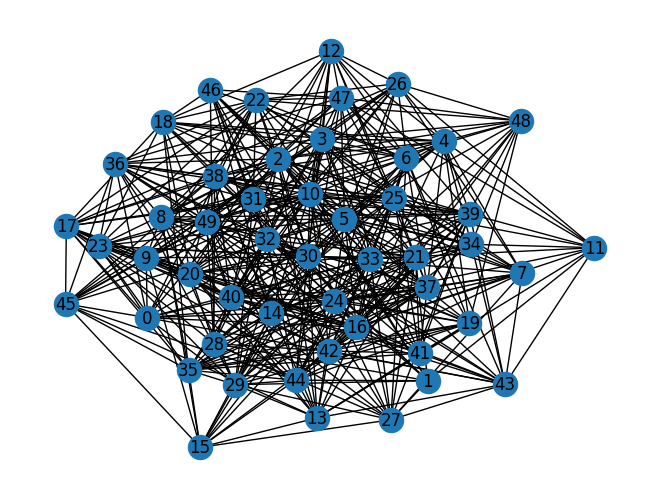

In [12]:
n=50
p=0.4
G=nx.erdos_renyi_graph(n, p)
nx.draw(G, with_labels=True)

Analysis Before the Attack

In [13]:
rnd_diameter=[]
rnd_avg_degree=[]
highest_degree_diameter=[]
highest_degree_avg_degree=[]

In [14]:
def measure(G):
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
   # print(f"Density: {nx.density(G)}")
   # print(f"Transitivity: {nx.transitivity(G)}")
    print(f"Max Degree: {max(dict(G.degree()).values())}")
    print(f"Min Degree: {min(dict(G.degree()).values())}")
    print(f"Average Degree: {np.mean(list(dict(G.degree()).values()))}")
    rnd_avg_degree.append(np.mean(list(dict(G.degree()).values())))
    highest_degree_avg_degree.append(np.mean(list(dict(G.degree()).values())))
    print(f"Number of components:{nx.number_connected_components(G)}")
    print(f"Assortativity: {nx.degree_assortativity_coefficient(G)}")
    betwenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    degree_centrality = nx.degree_centrality(G)
    print(f"Betweenness centrality max:{max(betwenness_centrality.values())}")
    print(f"Closeness centrality max:{max(closeness_centrality.values())}")
    print(f"Degree centrality max:{max(degree_centrality.values())}")

    if(nx.is_connected(G)):
        print("Graph is connected")
        print(f"Diameter: {nx.diameter(G)}")
        highest_degree_diameter.append(nx.diameter(G))
        rnd_diameter.append(nx.diameter(G))
    else:
        print("Graph is not connected")
        G=G.subgraph(max(nx.connected_components(G), key=len))
        highest_degree_diameter.append(nx.diameter(G))
        rnd_diameter.append(nx.diameter(G))


    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.title("Betweenness distribution")
    plt.hist(betwenness_centrality.values(), bins=100, log=True)

    plt.subplot(132)
    plt.title("Closeness distribution")
    plt.hist(closeness_centrality.values(), bins=100)

    plt.subplot(133)
    plt.title("Degree centrality distribution")
    plt.hist(degree_centrality.values())
    
    plt.show()
    fig, ax = plt.subplots(figsize=(5,3))

    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)
    plt.bar(*np.unique(degree_sequence, return_counts=True))
    #average degree vicino  alla mediana: 7 -> non è scale free

    fig.tight_layout()
    plt.show()

Number of nodes: 50
Number of edges: 457
Max Degree: 27
Min Degree: 11
Average Degree: 18.28
Number of components:1
Assortativity: -0.03367934294154821
Betweenness centrality max:0.027733108728006682
Closeness centrality max:0.6901408450704225
Degree centrality max:0.5510204081632653
Graph is connected
Diameter: 2


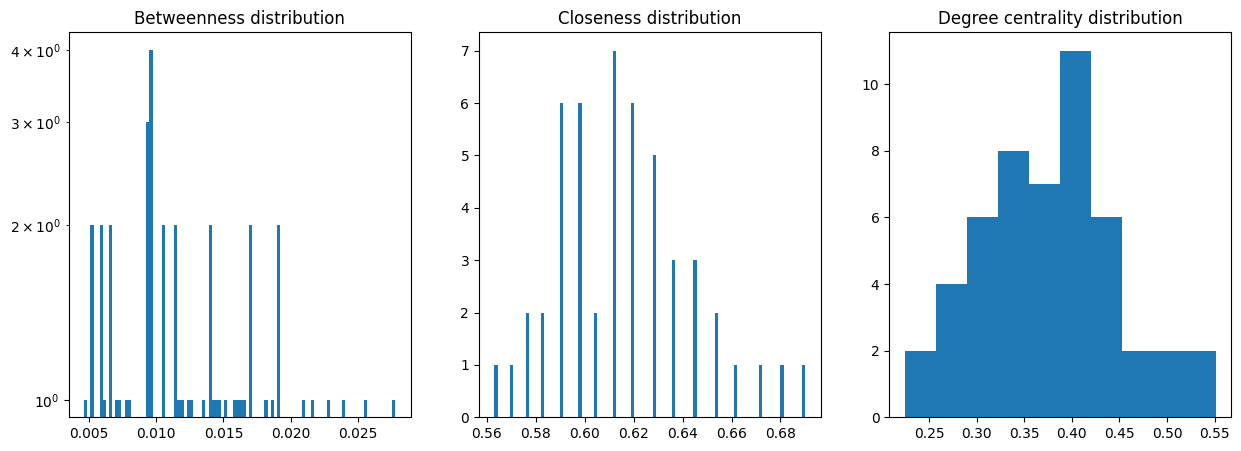

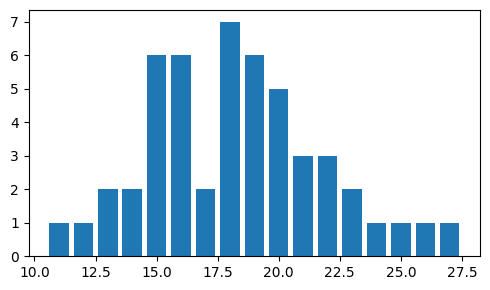

In [15]:
G_rand=G.copy()
measure(G)

Number of nodes: 45
Number of edges: 359
Max Degree: 23
Min Degree: 10
Average Degree: 15.955555555555556
Number of components:1
Assortativity: -0.059569571905921784
Betweenness centrality max:0.031232479494900222
Closeness centrality max:0.676923076923077
Degree centrality max:0.5227272727272727
Graph is connected
Diameter: 3


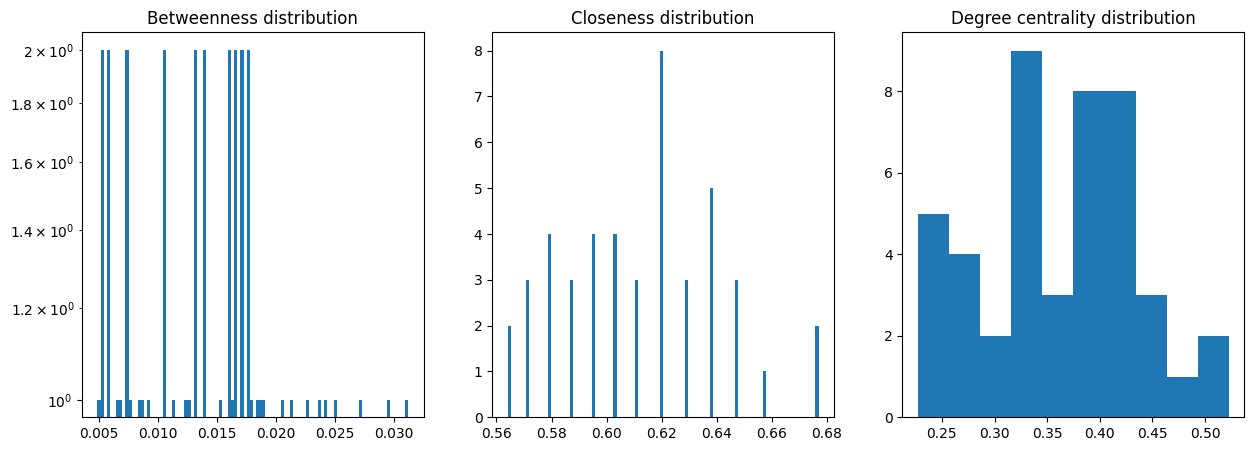

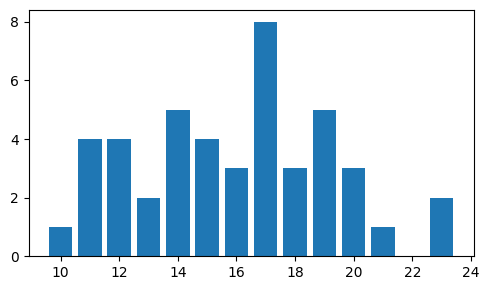

Number of nodes: 36
Number of edges: 241
Max Degree: 19
Min Degree: 9
Average Degree: 13.38888888888889
Number of components:1
Assortativity: -0.05673317249279836
Betweenness centrality max:0.040693373152008785
Closeness centrality max:0.6862745098039216
Degree centrality max:0.5428571428571428
Graph is connected
Diameter: 3


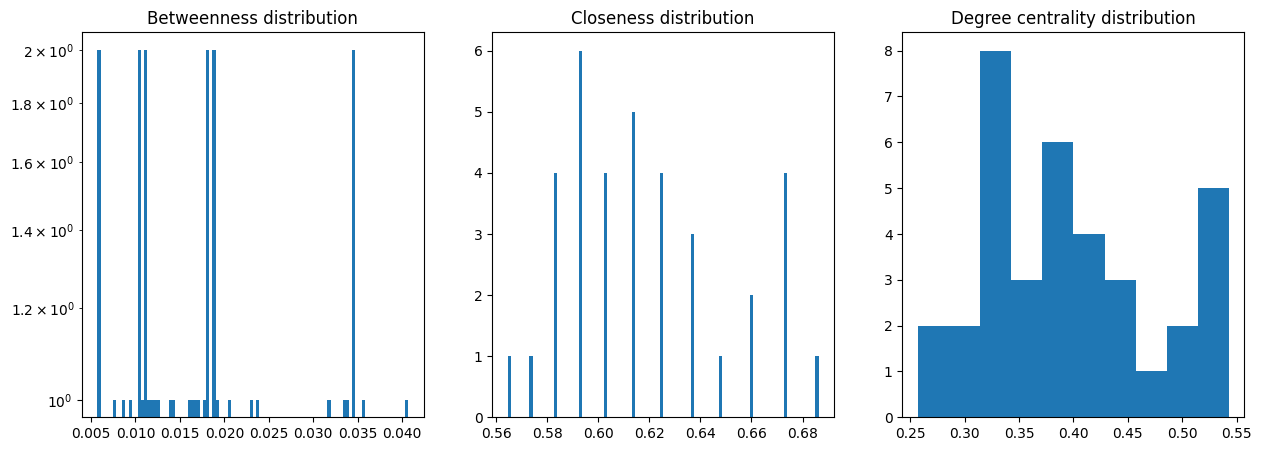

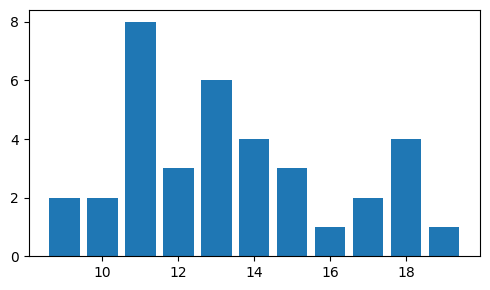

Number of nodes: 25
Number of edges: 106
Max Degree: 12
Min Degree: 5
Average Degree: 8.48
Number of components:1
Assortativity: -0.08577745025792279
Betweenness centrality max:0.08920265523526393
Closeness centrality max:0.6666666666666666
Degree centrality max:0.5
Graph is connected
Diameter: 3


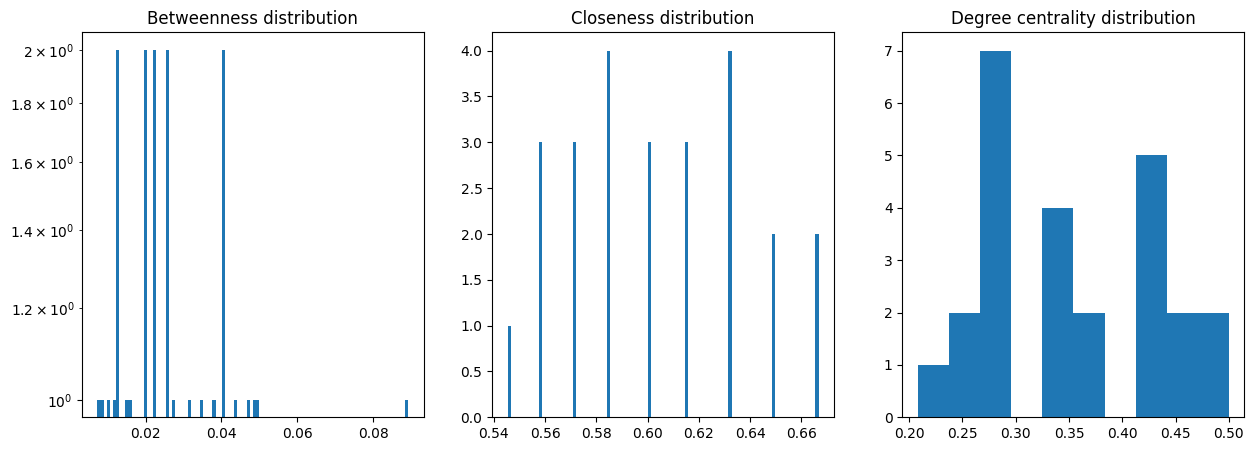

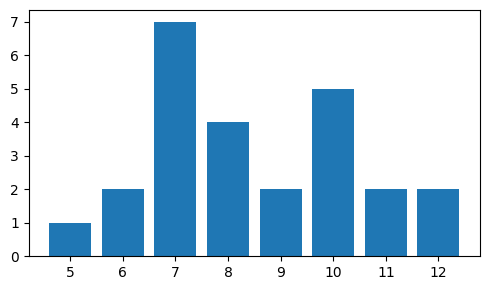

Number of nodes: 15
Number of edges: 36
Max Degree: 9
Min Degree: 2
Average Degree: 4.8
Number of components:1
Assortativity: -0.2405566600397637
Betweenness centrality max:0.24108748394462678
Closeness centrality max:0.7368421052631579
Degree centrality max:0.6428571428571428
Graph is connected
Diameter: 4


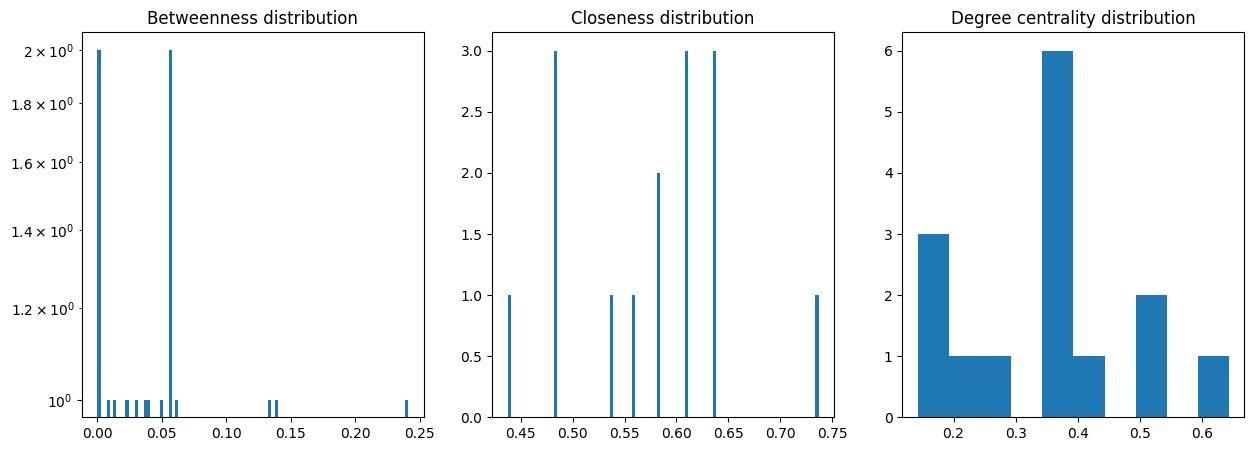

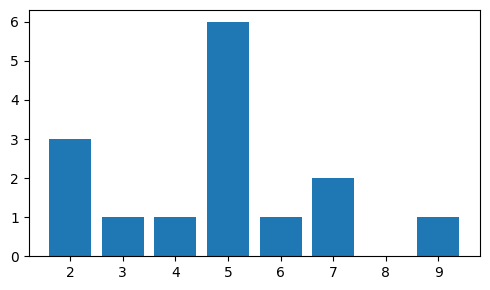

Number of nodes: 7
Number of edges: 6
Max Degree: 3
Min Degree: 0
Average Degree: 1.7142857142857142
Number of components:2
Assortativity: -0.6363636363636347
Betweenness centrality max:0.3333333333333333
Closeness centrality max:0.5952380952380952
Degree centrality max:0.5
Graph is not connected


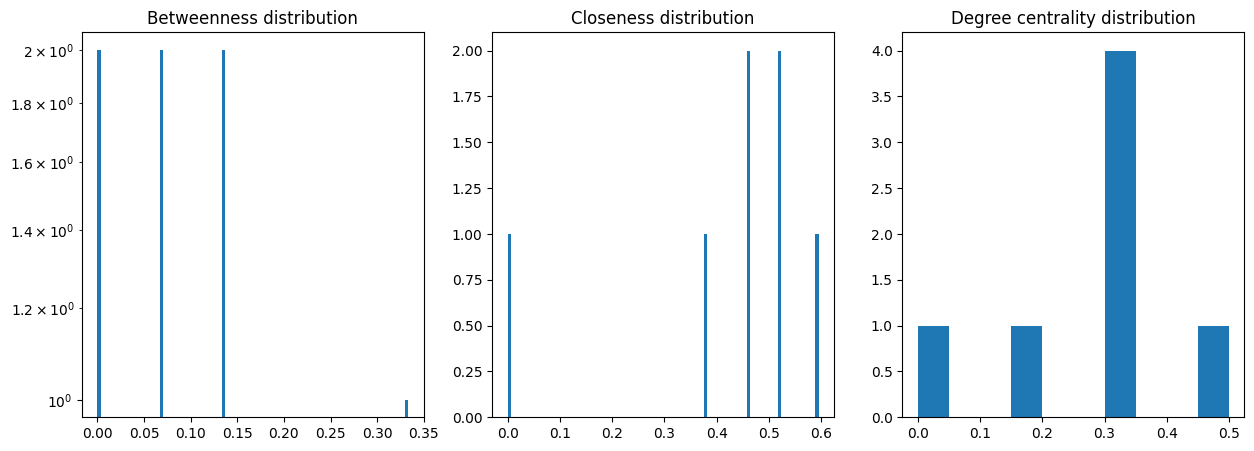

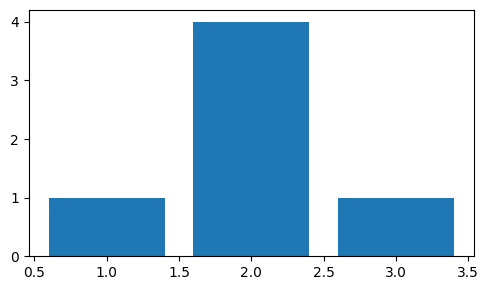

Number of nodes: 3
Number of edges: 1
Max Degree: 1
Min Degree: 0
Average Degree: 0.6666666666666666
Number of components:2
Assortativity: nan
Betweenness centrality max:0.0
Closeness centrality max:0.5
Degree centrality max:0.5
Graph is not connected


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/networkx/algorithms/assortativity/correlation.py:298: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


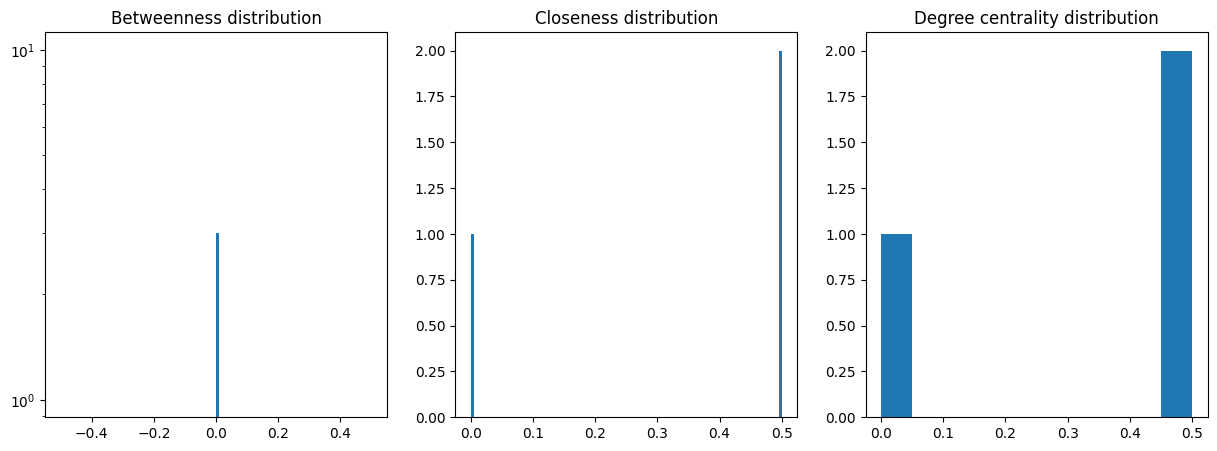

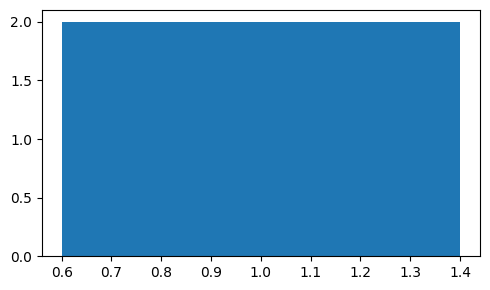

Number of nodes: 1
Number of edges: 0
Max Degree: 0
Min Degree: 0
Average Degree: 0.0
Number of components:1
Assortativity: nan
Betweenness centrality max:0.0
Closeness centrality max:0.0
Degree centrality max:1
Graph is connected
Diameter: 0


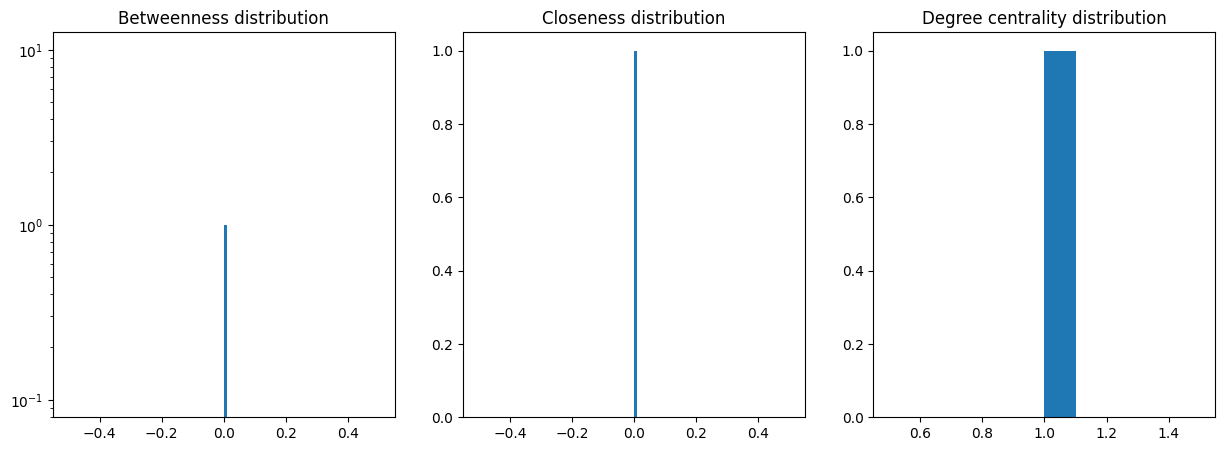

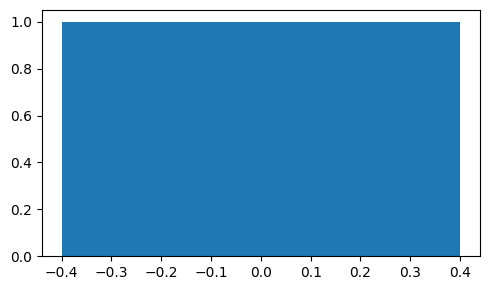

In [16]:
p=0.1
val_p=[]
while G.number_of_nodes() > 1:
    val_p.append(p)
    # Calculate the number of nodes to remove
    num_nodes = len(G.nodes())
    nodes_to_remove = round(num_nodes * p)

    # Randomly select nodes to remove
    nodes = list(G.nodes())
    nodes_to_remove = random.sample(nodes, nodes_to_remove)

    # Remove the selected nodes from the graph
    G.remove_nodes_from(nodes_to_remove)
    measure(G)
    p+=0.1


Plot distribution of Diameter and Average degree

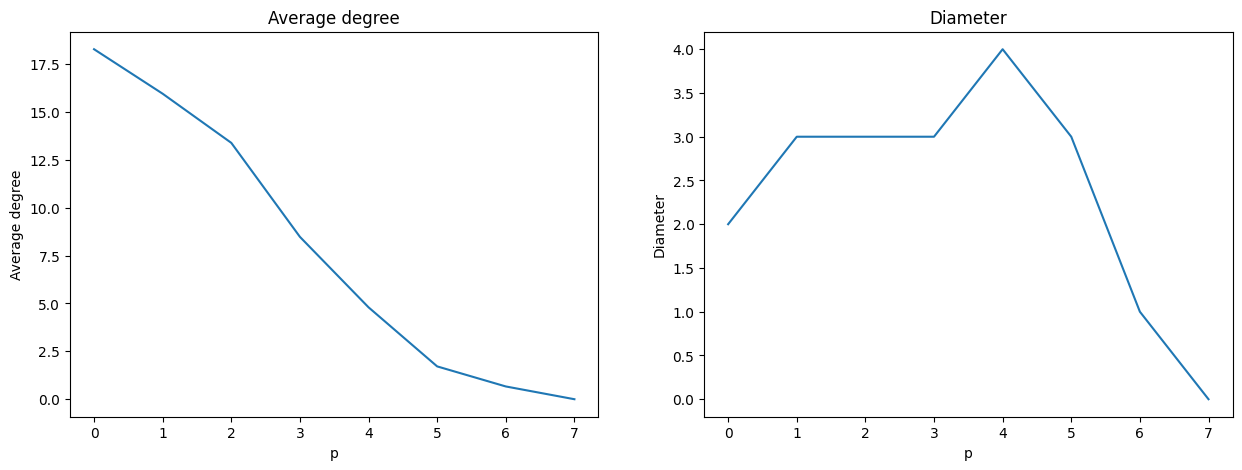

In [17]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Average degree")
#x labels = val_p normalizzati

plt.xlabel("p")
plt.ylabel("Average degree")
plt.plot(rnd_avg_degree)

plt.subplot(122)
plt.title("Diameter")
plt.xlabel("p")
plt.ylabel("Diameter")
plt.plot(rnd_diameter)

plt.show()

In [18]:
print(len(val_p))

7


## Remove Node with Highest Degree